<a href="https://colab.research.google.com/github/irene951/ML/blob/main/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from scipy.linalg import eigh
from scipy.linalg import inv

#**Load Datasets**

### Overview of the Iris Dataset
The dataset contains 150 samples of flowers from three different species of iris.

Each species has 50 samples, and the dataset provides four features for each flower, measured in centimeters.

In [3]:
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

### Visualize the original data
Use seaborn to create pair plot of original data

Text(0.5, 1.02, 'Pair Plot of Iris Dataset by Species')

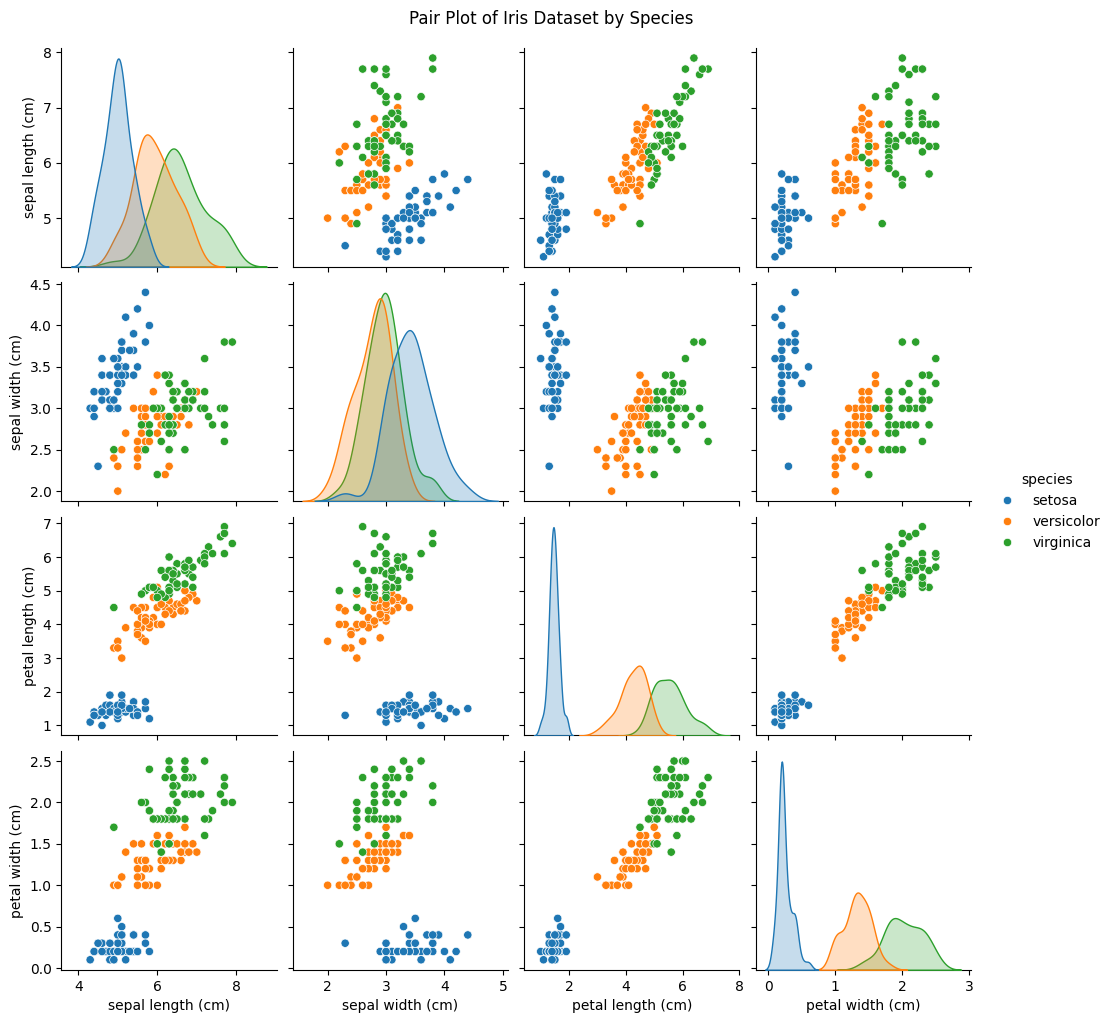

In [11]:
# 將資料轉換為 pandas DataFrame，並加上欄位名稱
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
# 將目標變數 (target) 也加入 DataFrame，並轉換為可讀的種類名稱
iris_df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

# 使用 seaborn 建立 pair plot
# hue='species' 會根據 'species' 欄位將資料點用不同顏色標示
sns.pairplot(iris_df, hue='species')

plt.suptitle('Pair Plot of Iris Dataset by Species', y=1.02)

Part 1: Principal Component Analysis (PCA)

PCA is an **unsupervised** method that aims to find the directions (principal components) that maximize the **variance** of the data.

## Implementation Steps:
1. Standardize the data.
2. Calculate the Covariance Matrix.
3. Solve for Eigenvalues and Eigenvectors.
4. Select the top $k$ components and project.

In [5]:
def standardize_data(X):
    """Standardize data (zero mean, unit variance)"""
    mean = np.mean(X, axis=0)
    std_dev = np.std(X, axis=0)
    std_dev[std_dev == 0] = 1
    X_std = (X - mean) / std_dev
    return X_std

def calculate_covariance_matrix(X_std):
    """Calculate the Covariance Matrix"""
    n_samples = X_std.shape[0]
    # TODO: Calculate the Covariance Matrix (Hint: Matrix multiplication)
    cov_matrix = np.dot(X_std.T, X_std)/(n_samples-1)
    return cov_matrix

def pca(X, n_components):
    """Execute PCA"""
    X_std = standardize_data(X)
    cov_matrix = calculate_covariance_matrix(X_std)

    # Solve for Eigenvalues/vectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    eigen_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]

    # Sort: descending order
    # TODO: Fill in the key for sorting Eigenpairs
    eigen_pairs.sort(key = lambda x: x[0], reverse=True)

    W = np.array([eigen_pairs[i][1] for i in range(n_components)]).T

    # Project
    # TODO: Fill in the projection formula
    X_pca = np.dot(X_std, W)

    return X_pca, W, eigen_pairs

# Execute PCA (Reduce to 2 dimensions)
n_components_pca = 2
X_pca, W_pca, eigen_pairs_pca = pca(X, n_components_pca)

PCA visualization

--- PCA Projection ---


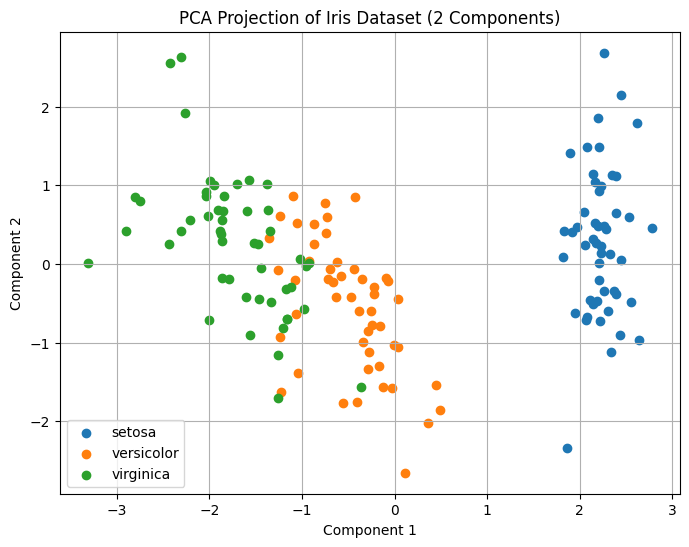

In [9]:
def plot_reduced_data(X_reduced, y, title):
    """Visualize the 2D reduced data"""
    plt.figure(figsize=(8, 6))
    for i, target_name in enumerate(target_names):
        plt.scatter(X_reduced[y == i, 0], X_reduced[y == i, 1], label=target_name)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

print("--- PCA Projection ---")
plot_reduced_data(X_pca, y, 'PCA Projection of Iris Dataset (2 Components)')

Part 2: Linear Discriminant Analysis (LDA)

LDA is a **supervised** method that aims to find the directions that maximize the ratio of **Between-Class Scatter (SB)** to **Within-Class Scatter (SW)** for optimal class separation.

## Implementation Steps:
1. Calculate SW and SB.
2. Solve the generalized eigenvalue problem SB(SW^-1 * SB).
3. Select the top c-1 (2 for Iris) discriminant components and project.

In [7]:
def calculate_scatter_matrices(X, y):
    """Calculate S_W and S_B"""

    n_features = X.shape[1]
    unique_classes = np.unique(y)

    mean_overall = np.mean(X, axis=0)

    # S_W
    S_W = np.zeros((n_features, n_features))
    for i in unique_classes:
        X_class = X[y == i]
        # TODO: Fill in the logic for S_i or the sum of within-class covariances
        scatter_i = np.dot((X_class - np.mean(X_class, axis=0)).T,
                   (X_class - np.mean(X_class, axis=0)))
        S_W += scatter_i

    # S_B
    S_B = np.zeros((n_features, n_features))
    for i in unique_classes:
        X_class = X[y == i]
        n_i = X_class.shape[0]
        mean_class = np.mean(X_class, axis=0)
        mean_diff = (mean_class - mean_overall).reshape(n_features, 1)

        # TODO: Fill in the logic for n_i * (mean_diff * mean_diff.T)
        S_B += n_i * np.dot(mean_diff, mean_diff.T)

    return S_W, S_B

def lda(X, y, n_components):
    """Execute LDA"""

    S_W, S_B = calculate_scatter_matrices(X, y)

    # Tikhonov Regularization to handle S_W singularity
    epsilon = 1e-6
    S_W_reg = S_W + epsilon * np.identity(S_W.shape[0])

    # Solve S_W^-1 * S_B
    S_W_inv = inv(S_W_reg)
    M = np.dot(S_W_inv, S_B)

    eigenvalues, eigenvectors = np.linalg.eig(M)
    eigenvalues = eigenvalues.real
    eigenvectors = eigenvectors.real

    eigen_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]

    # Sort: descending order
    # TODO: Fill in the key for sorting Eigenpairs
    eigen_pairs.sort(key = lambda x:x[0], reverse=True)

    W = np.array([eigen_pairs[i][1] for i in range(n_components)]).T

    # Project
    # TODO: Fill in the projection formula
    X_lda = np.dot(X, W)

    return X_lda, W, eigen_pairs

# Execute LDA (Reduce to 2 dimensions)
n_components_lda = 2
X_lda, W_lda, eigen_pairs_lda = lda(X, y, n_components_lda)

LDA Visualization and Summary


--- LDA Projection ---


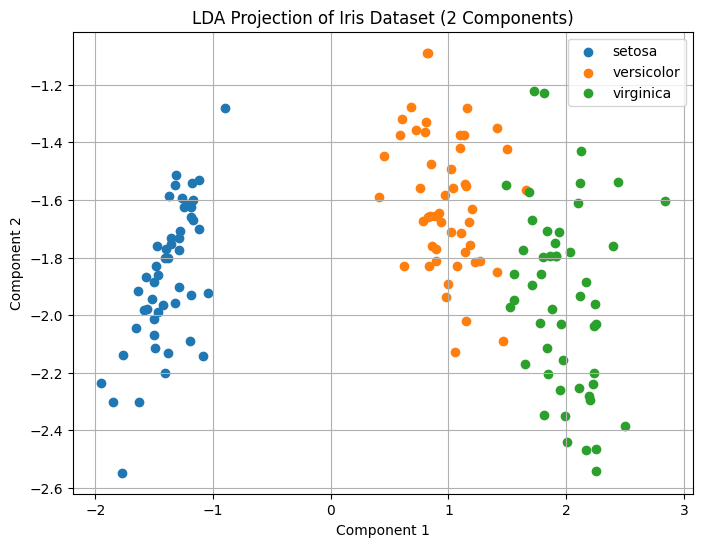


--- Summary Data (for Report) ---
PCA Eigenvalues (Variance): [np.float64(2.9380850501999958), np.float64(0.9201649041624861)]
LDA Eigenvalues (Between/Within Ratio): [np.float64(32.19192574115118), np.float64(0.2853910161900479)]


In [8]:
print("\n--- LDA Projection ---")
plot_reduced_data(X_lda, y, 'LDA Projection of Iris Dataset (2 Components)')

# Output summary data for the report
print("\n--- Summary Data (for Report) ---")
# Assuming you captured eigen_pairs_pca earlier
print("PCA Eigenvalues (Variance):", [pair[0] for pair in eigen_pairs_pca][:2])
print("LDA Eigenvalues (Between/Within Ratio):", [pair[0] for pair in eigen_pairs_lda][:2])